# 大相撲の試合の予測


このノートでは、大相撲のデータセットを分析していきます。ウェブサイト[Data World](https://data.world/cervus/sumo-japan) 」には、相撲の試合結果のデータセット、1983年以降の力士の特性のデータセット、2017年以降の試合の勝算のデータセットがあります。


それぞれの変数についての説明は[こちら](https://data.world/cervus/sumo-japan/workspace/data-dictionary)をご覧ください。


## 目的

大相撲の試合の結果を予測すること。

### 目次

<b>1.データ分析</b>
* 1.1.基本的な分析。
* 1.2.行方不明のデータ。
* 1.3.最も勝利数の多い3人の選手は誰か。
* 1.4.大相撲の力士の身長と体重。
* 1.5.最も多く力士を育てたのはどこの部屋か。
* 1.6.大相撲の力士はどこの出身ですか。

<b>2.正確な勝算</b>
* 2.1.勝算と結果の変数のための新しい変数。
* 2.2.勝算と結果のデータフレームのための新しい変数。
* 2.3.結果。

<b>3.試合結果の予測</b>
* 3.1.試合結果の予測。
* 3.2.トレーニングとテストのためのデータ分割。
* 3.3.モデリング。

In [1]:
#Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

[GitHub](https://github.com/ElieSDK/Sumo_Match_Prediction/tree/main/Data)でもデータセットをダウンロードができます。

In [2]:
#データセットのを読みます
banzuke = pd.read_csv('banzuke.csv')
odds = pd.read_csv('odds.csv')
results = pd.read_csv('results.csv')

## 1.データ分析
### 1.1.基本的な分析

In [3]:
#最初のデータフレームを確認します
banzuke.head()

,basho,id,rank,rikishi,heya,shusshin,birth_date,height,weight,prev,prev_w,prev_l
0,1983.01,1354,Y1e,Chiyonofuji,Kokonoe,Hokkaido,1955-06-01,182.0,116.0,Y1e,14.0,1.0
1,1983.01,4080,Y1w,Kitanoumi,Mihogaseki,Hokkaido,1953-05-16,179.0,165.0,Y2eHD,9.0,3.0
2,1983.01,4095,Y2eHD,Wakanohana,Futagoyama,Aomori,1953-04-03,186.0,133.0,Y1w,0.0,0.0
3,1983.01,4104,O1e,Takanosato,Futagoyama,Aomori,1952-09-29,181.0,144.0,O1e,10.0,5.0
4,1983.01,4112,O1w,Kotokaze,Sadogatake,Mie,1957-04-26,183.0,163.0,O1w,10.0,5.0


番付データベースには、1983年から2021年までの各大会について、日付、力士名、番号ID、各力士の部屋、出身地、生年月日、身長、体重、番付、前座が含まれています。

In [4]:
odds.head()

,rikishi1,odds1,rikishi2,odds2,ts
0,Arawashi,1.8,Ura,2.01,2017-05-13 09:00:01
1,Daishomaru,1.9,Onosho,1.90,2017-05-13 09:00:01
2,Goeido,1.3,Okinoumi,3.52,2017-05-13 09:00:01
3,Hakuho,1.1,Chiyonokuni,7.00,2017-05-13 09:00:01
4,Harumafuji,1.4,Kotoshogiku,2.96,2017-05-13 09:00:01


勝算データベースには、2017年から2021年までの各戦いの勝算が含まれます。勝算は時間の経過とともに微妙に変化するため、1つの試合が多くの勝算を持つことがあります。

In [5]:
results.head()

,basho,day,rikishi1_id,rikishi1_rank,rikishi1_shikona,rikishi1_result,rikishi1_win,kimarite,rikishi2_id,rikishi2_rank,rikishi2_shikona,rikishi2_result,rikishi2_win
0,1983.01,1,4140,J13w,Chikubayama,0-1 (7-8),0,yorikiri,4306,Ms1e,Ofuji,1-0 (6-1),1
1,1983.01,1,4306,Ms1e,Ofuji,1-0 (6-1),1,yorikiri,4140,J13w,Chikubayama,0-1 (7-8),0
2,1983.01,1,1337,J12w,Tochitsukasa,1-0 (9-6),1,oshidashi,4323,J13e,Shiraiwa,0-1 (3-12),0
3,1983.01,1,4323,J13e,Shiraiwa,0-1 (3-12),0,oshidashi,1337,J12w,Tochitsukasa,1-0 (9-6),1
4,1983.01,1,4097,J12e,Tamakiyama,0-1 (8-7),0,yorikiri,4319,J11w,Harunafuji,1-0 (5-10),1


結果データベースには、1983年から2021年までの各対戦の結果が含まれます。力士の現在の順位や、勝ち技などの情報もあります。

In [6]:
banzuke.describe(include=['O'])

,rank,rikishi,heya,shusshin,birth_date,prev
count,169105,169105,169105,169105,168442,169026
unique,995,5890,73,74,4199,996
top,Sd16e,Hokutoryu,Sadogatake,Tokyo,1970-11-22,Mz
freq,230,218,8098,12711,282,4816


この関数によると、番付データベースには、74都市、73部屋、5890人のユニークな力士が含まれます。

### 1.2.行方不明のデータ

In [7]:
banzuke.isnull().sum(axis = 0)

basho            0
id               0
rank             0
rikishi          0
heya             0
shusshin         0
birth_date     663
height        5174
weight        5174
prev            79
prev_w          79
prev_l          79
dtype: int64

主に身長と体重に関するデータが欠落しています。データベース(169,105行)に対して欠落データはわずかなので、これらの欠落情報を持つ行を削除します:

In [8]:
banzuke = banzuke.dropna()

### 1.3.最も勝利数の多い3人の選手は誰か

まず、欠落した情報を取り除いた後に、何人のユニークな力士がいるか見ます:

In [9]:
unique_id = banzuke.drop_duplicates(subset=['id'])
print("ユニークな力士の数は",unique_id['id'].count(),"人です。")

ユニークな力士の数は 4949 人です。


結果のデータフレームから、力士を勝利数の多い順に並べることができます。

In [10]:
results[['rikishi1_shikona', 'rikishi1_win']].groupby(['rikishi1_shikona'],
                                      as_index=False).count().sort_values(
                                          by='rikishi1_win',ascending=False).head(n=10)

,rikishi1_shikona,rikishi1_win
361,Kyokutenho,1715
14,Aminishiki,1700
236,Kaio,1662
604,Terao,1580
624,Tochinowaka,1518
682,Wakanosato,1467
649,Tosanoumi,1444
332,Kotonowaka,1428
577,Takekaze,1419
336,Kotoshogiku,1399


4949人の力士の中で、最も多くの勝ち星をあげているのは、旭天鵬で(Kyokutenho)、1715回の勝ち星をあげています。

### 1.4.大相撲の力士の身長と体重

In [11]:
print("相撲の平均身長は",round(banzuke["height"].mean(),1),"センチです。")

相撲の平均身長は 179.6 センチです。


In [12]:
print("相撲の平均体重は",round(banzuke["weight"].mean(),1),"キロです。")

相撲の平均体重は 125.2 キロです。


力士の平均身長は179.6センチ、平均体重は125.2キロです。

力士の名前を入れると、その力士の身長と体重の推移を描くことができます。<br>
今回の例では、大相撲の大内選手(Osonai)に決めました。

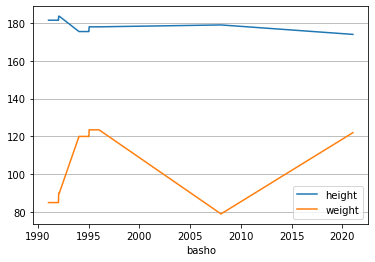

In [13]:
sumo_HW = banzuke.loc[banzuke['rikishi'] == 'Osanai']
sumo_HW.plot(x="basho", y=["height", "weight"], kind="line")
plt.grid(axis='y', linestyle='-')

2008年からの30年間で、身長はわずかに減少しました。一方、体重は85kgから120kgまで変化しました。

どの部屋に平均して最も背が高く、最も重い力士がいるかを探しましょう:

In [14]:
banzuke[['height', 'heya']].groupby(['heya'],
                                      as_index=False).mean().sort_values(
                                          by='height',ascending=False).head(n=15)

,heya,height
63,Takekuma,185.870000
36,Nakadachi,182.223810
22,Kataonami,181.803420
18,Kabutoyama,181.474161
23,Kiriyama,181.179685
65,Tatsunami,181.125287
5,Azumazeki,181.069661
11,Hanakago,180.974734
58,Taiho,180.912208
48,Oshima,180.811368


身長の違いはわずかで、力士の身長は平均180cmから185cm、武隈部屋の平均は185cmです。

In [15]:
banzuke[['weight', 'heya']].groupby(['heya'],
                                      as_index=False).mean().sort_values(
                                          by='weight',ascending=False).head(n=15)

,heya,weight
63,Takekuma,166.220000
68,Tokiwayama,144.174194
6,Chiganoura,140.242820
24,Kise,139.321056
14,Irumagawa,136.884796
60,Takanohana,136.619062
71,Yamahibiki,135.281737
5,Azumazeki,134.846962
25,Kitanoumi,132.280533
53,Sakaigawa,132.196249


どうして初代と二代の部屋でこれほどの差があるのでしょうか？<br>

竹熊部屋について詳しく見てみましょう。<br>
データセットには、竹熊部屋の相撲試合は何試合あるのでしょうか。

In [16]:
banzuke['heya'].value_counts(ascending=True)

Tokiwayama      31
Takekuma        50
Oyama           94
Nishiiwa       120
Nakadachi      126
              ... 
Kokonoe       5058
Takasago      5276
Dewanoumi     5684
Kasugano      6196
Sadogatake    7859
Name: heya, Length: 72, dtype: int64

竹熊部屋の力士が出場したのは50試合だけで、力士は羽黒国1人だけのようです。

In [17]:
banzuke.loc[banzuke['heya'] == 'Takekuma', 'rikishi'].unique()

array(['Haguronada', 'Haguroshima', 'Hagurokuni'], dtype=object)

2004年4月に書かれたこの[記事によると、](http://www.info-sumo.net/forum/content/380-La-Takekuma-beya-c-est-fini%21?s=746eab80535851b5db86619ecc5d5180) 確かにこの部屋には力士が一人しかいませんでした。<br>
武隈親方（...）は同名の部屋を閉鎖することを決めました。唯一の弟子である羽黒国のキャリアが終わった後、弟子なしで部屋を存続させることが困難になりました。

### 1.5.最も多く力士を育てたのはどこの部屋か

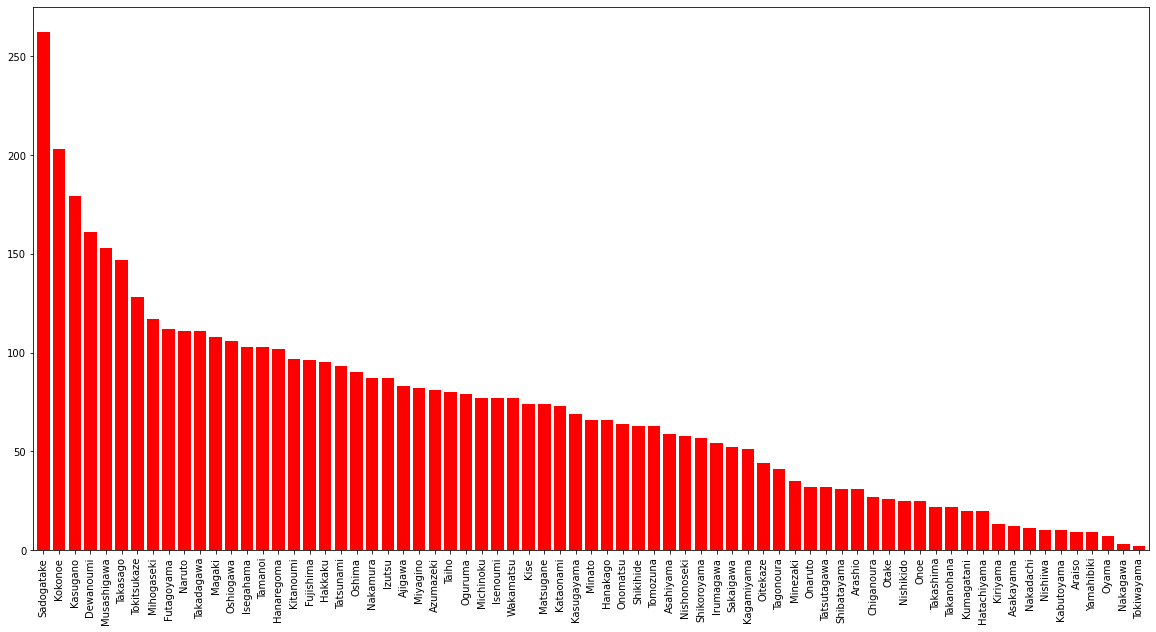

In [18]:
unique_id['heya'].value_counts().plot(kind="bar", 
                                     legend=False,
                                     color='red',
                                     width=0.8, 
                                     figsize=(20,10))
plt.show()

最も多くの力士を育てている部屋は佐渡ヶ嶽、九重、春日野です。

### 1.6.大相撲の力士はどこの出身ですか

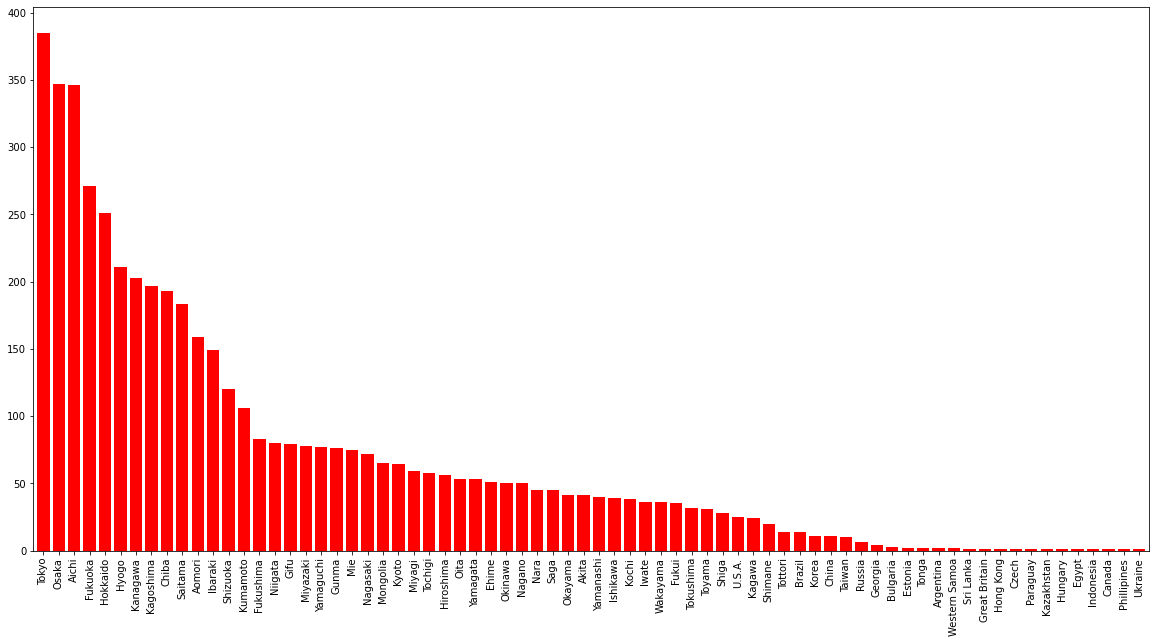

In [19]:
unique_id['shusshin'].value_counts().plot(kind="bar", 
                                     legend=False,
                                     color='red',
                                     width=0.8, 
                                     figsize=(20,10))
plt.show()

相撲は主に東京、大阪、愛知から来ています。各部屋には外国人力士を一人育成する権利がありますので、外国人力士もいます。

## 2.正確な勝算
ブックメーカーの勝算が正確かどうかを調べるために、勝算と結果のデータフレームに新しい変数を作成します。<br>

### 2.1.勝算と結果の変数のための新しい変数。
勝算のデータフレームの場合。<br>

第一力士のが第二力士の勝算よりも大きい場合: yyyy.mm.rikishi1>rikishi2<br>
それ以外の場合は yyy.mm.rikishi2>rikishi1<br>
(備考、力士は月に1回(1ヶ月に1回の場所)でしか会えませんが、1年に何度も会うことができます。)

In [20]:
odds['merged_odds'] = np.where(odds['odds1']>odds['odds2'],
                               odds['ts'].str[:7] + "." + odds['rikishi1'] + ">" + odds['rikishi2'], 
                               odds['ts'].str[:7] + "." + odds['rikishi2'] + ">" + odds['rikishi1'])

イコールがある場合は:

In [21]:
odds['merged_odds'] = np.where(odds['odds1'] == odds['odds2'],
                               odds['ts'].str[:7] + "." + odds['rikishi1'] + "=" + odds['rikishi2'],
                               odds['merged_odds'])

odds['merged_odds'] = odds['merged_odds'].str.replace('-','.')

In [22]:
odds['merged_odds']

0                  2017.05.Ura>Arawashi
1             2017.05.Daishomaru=Onosho
2               2017.05.Okinoumi>Goeido
3            2017.05.Chiyonokuni>Hakuho
4        2017.05.Kotoshogiku>Harumafuji
                      ...              
20019     2021.01.Shimanoumi>Takarafuji
20020        2021.01.Takanosho>Takayasu
20021         2021.01.Meisei>Terunofuji
20022     2021.01.Daishomaru>Tokushoryu
20023       2021.01.Yutakayama>Myogiryu
Name: merged_odds, Length: 20024, dtype: object

"2017.05.Ura>Arawashi "というのは、2017年5月にUra VS Arawashiの試合において、Uraの勝算がArawashiの勝算よりも高かったです。

In [23]:
odds['merged_odds'].describe()

count                     20024
unique                     5933
top       2019.11.Enho>Shohozan
freq                         52
Name: merged_odds, dtype: object

勝算は時間とともに変化することがあるので、5,933のユニークな試合をカバーする20,024の勝算があります。

重複を取り除きましょう。

In [24]:
odds['merged_odds'] = odds['merged_odds'].drop_duplicates()

In [25]:
odds['merged_odds'].describe()

count                     5933
unique                    5933
top       2017.05.Ura>Arawashi
freq                         1
Name: merged_odds, dtype: object

結果のデータフレームです:<br>

名前と日付を連結するためには、Basho列をfloat64型からstringに、Resultsをobjectからfloat64に変換する必要があります。

In [ ]:
results['basho'] = results['basho'].apply(str)

results['rikishi1_win'] = results['rikishi1_win'].apply(float)
results['rikishi2_win'] = results['rikishi2_win'].apply(float)

results['merged_results'] = np.where(results['rikishi1_win']>results['rikishi2_win'],
                               results['basho'] + "." + results['rikishi1_shikona'] + ">" + results['rikishi2_shikona'], 
                               results['basho'] + "." + results['rikishi2_shikona'] + ">" + results['rikishi1_shikona'])

results['merged_results']

「2021.05.Terunofuji>Takakeisho」というのは、2021年5月にTerunofuji vs Takakeishoの試合で、TerunofujiがTakakeishoに勝ちました。

### 2.2.勝算と結果のデータフレームのための新しい変数
これらの列を連結するためには、まず、以下のことが必要です。
<ul>
<li>serieをdataframeに変換する。</li>
<li>重複を削除する。</li>
<li> インデックスを並べ替える。</li>
</ul>

In [ ]:
data_results = results['merged_results']
data_results = data_results.to_frame(name='merged_results')
data_results = data_results.drop_duplicates()
data_results = data_results.reset_index(drop=True)

data = [odds['merged_odds'], data_results['merged_results']]
compare = pd.concat(data, axis=1, keys=["odds", "results"])

compare.head()

In [ ]:
compare.describe()

今データベースには5933のユニークなオッズと109,923の試合結果があります。

### 2.3.結果
勝算の値が結果の列にあれば、予測は正しかった、そうでなければ間違いです。

In [ ]:
simi = compare.odds.isin(compare.results)
print("勝算のデータセットと結果のデータセットの間の類似性の数は",sum(simi),"です。")

In [ ]:
first = pd.Series({'True': sum(simi), 'False': len(compare['odds'].unique())-sum(simi)})
plt.pie(first, labels = {'True','False'}, autopct='%1.1f%%')
plt.title('Odds vs Results')
plt.axis('equal')
plt.show()

予測の39%が正しく、61%が間違っていました(5933個のオッズのうち、2316個が正しい)。

## 3.試合結果の予測
### 3.1.機能エンジニアリングとデータの前処理
試合の結果を予測するためには、予測モデルに無関係な特徴を削除する必要があります。<br>
そこで、力士のID、勝敗、各力士の特徴量を含むデータセットを作成します。

In [ ]:
merged_fi = pd.read_csv('results.csv')

merged_fi = merged_fi.drop(['day','rikishi1_rank','rikishi2_rank',
                            'rikishi1_shikona','rikishi2_shikona','rikishi1_result','kimarite',
                            'rikishi2_result'],axis=1)

#インデックスの再作成、Fighter1のリネーム、マージ(Fighter2にも同様の作業を行う必要があります）
merged_fi = merged_fi.rename(columns = {'rikishi1_id':'id'})
merged_fi = merged_fi.sort_values('id')
merged_fi = pd.merge(merged_fi, unique_id, on="id")

merged_fi = merged_fi.rename(columns = {'id':'rikishi1_id',
                                        'height':'height1',
                                        'weight':'weight1'})

merged_fi = merged_fi.rename(columns = {'rikishi2_id':'id'})
merged_fi = merged_fi.sort_values('id')
merged_fi = pd.merge(merged_fi, unique_id, on="id")

merged_fi = merged_fi.rename(columns = {'height':'height2',
                                        'weight':'weight2',
                                        'id':'rikishi2_id',
                                        'basho_x':'basho'})

#必要な変数を選択
merged_ml = merged_fi[['rikishi1_id',
                       'rikishi1_win',
                       'rikishi2_id',
                       'height1',
                       'weight1',
                       'height2',
                       'weight2']]

merged_ml.head()

In [ ]:
merged_ml.shape

新しいデータベースには、220,592の試合結果、相撲の身長と体重が含まれています。

### 3.2.トレーニングとテストのためのデータ分割

In [ ]:
merged_ml = shuffle(merged_ml)

In [ ]:
X=merged_ml.drop(['rikishi1_win','rikishi1_id','rikishi2_id'],axis=1) #相撲IDと勝者の結果を削除します
y=merged_ml['rikishi1_win']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

In [ ]:
#モデルの初期化とデータのフィッティング
#LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
train_score=model.score(X_train,y_train)
test_score=model.score(X_test,y_test)
print("学習精度: ",train_score)
print("テスト精度: ",test_score)

logistic regressionモデルを使うことで、トレーニングの精度は51%近くになりましたが、このスコアを改善できるかどうか、他のモデルを試してみましょう。

### 3.3.モデリング

In [ ]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), 
                             SelectKBest(f_classif, k=10))

RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0)) 
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

モデルにはパイプラインを使用します。パイプラインは複数の推定量を1つにまとめるために使用されます。<br>

プリプロセッサには2つの特徴があります:<br>
<ul>
<li>PolynomialFeaturesは、多項式特徴と相互作用特徴を生成します。より正確には，指定された次数以下の特徴のすべての多項式の組み合わせからなる新しい特徴行列を生成します．</li>

<li>SelectKBest は，Yとの依存性テストのスコアが最も高いK個の変数Xを選択します．</li>
</ul>
<br>
PolynomialFeaturesはデータを修正するので、モデリング・プロセスの前にデータを正規化するために、StandardScaler()を使用しなければなりません。<br>

そのため、4つのモデルをテストします :Random Forest, Ada Boost, SVN。<br>

In [ ]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

結論:<br>

RandomForestが最も良い結果を出し、Recallが55%となりました。<br>
これにより、スコアが51%から55%に向上しました。<br>
実際は、賭けに失敗するとお金を失うことになるので、リコールは可能な限り100%に近づけたいと考えています。<br>

したがって、モデルは、大相撲の試合結果を55%の精度で予測することができます。<br>